Тетрадка для обучения модели.

# Import

In [63]:
import os
import sys
from dotenv import load_dotenv
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import category_encoders as ce

import torch
from torch.utils.data import Dataset

from xgboost import XGBRegressor


load_dotenv()
sklearn.set_config(transform_output="pandas")
pd.options.display.max_columns = None
ROOT_PATH = os.getenv("ROOT_PATH")
sys.path.append(ROOT_PATH)

In [64]:
from src.metrics import get_smoothed_mean_log_accuracy_ratio

# Config

In [66]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

# Train

In [67]:
ds = pd.read_csv(os.path.join(INPUT_DATA_PATH, "dataset.csv"))

In [ ]:
# ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "dataset.csv"), index=False)

In [68]:
ds = ds.drop(columns=["publishers", "user_ids"])
ds = ds.sort_values(by="hour_start_old").reset_index(drop=True)
ds.head()

,cpm,hour_start_old,hour_end,audience_size,weekday_start,duration,hour_start,publisher_quantity,used_publishers_ration,top_time_month,top_time_week,top_weekday_month,top_weekday_week,session_duration_month_mean,session_duration_week_mean,session_quantity_month,session_quantity_week,session_cpm_month_mean,session_cpm_week_mean,views_month_mean,views_week_mean,at_least_one,at_least_two,at_least_three
0,35.0,747,806,1000,3,59,3,4,0.288493,20,22,2,3,2,2,9499,2148,217.545371,221.634882,19862,4462,71,30,10
1,63.0,747,955,1080,3,208,3,2,0.554154,21,15,2,0,2,2,8071,1910,116.115024,113.356986,14143,3493,336,228,183
2,190.0,748,823,1210,3,75,3,1,1.000000,21,22,2,2,2,2,10058,2390,208.450657,217.187204,20255,4916,58,19,10
3,150.0,748,1019,696,3,271,3,2,0.534483,20,21,0,1,2,2,6867,1555,218.536409,201.772042,14442,3260,61,40,27
4,40.0,748,760,332,3,12,3,5,0.236667,21,16,2,3,2,2,3325,726,206.201625,216.208685,7122,1557,6,1,0


## Feature scaling

<Axes: xlabel='hour_start_old'>

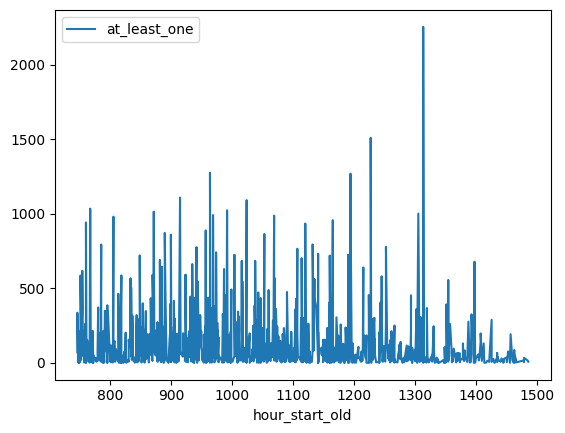

In [19]:
ds.plot(x="hour_start_old", y="at_least_one")

In [69]:
scaler = MinMaxScaler()
scaled_ds = scaler.fit_transform(ds[['cpm', 'hour_start_old', 'hour_end', 'audience_size', 'weekday_start',
                                     'duration', 'hour_start', 'publisher_quantity',
                                     'top_time_month', 'top_time_week',
                                     'top_weekday_month', 'top_weekday_week', 'session_duration_month_mean',
                                     'session_duration_week_mean', 'session_quantity_month',
                                     'session_quantity_week', 'session_cpm_month_mean',
                                     'session_cpm_week_mean', 'views_month_mean', 'views_week_mean']])
scaled_ds.head()

,cpm,hour_start_old,hour_end,audience_size,weekday_start,duration,hour_start,publisher_quantity,top_time_month,top_time_week,top_weekday_month,top_weekday_week,session_duration_month_mean,session_duration_week_mean,session_quantity_month,session_quantity_week,session_cpm_month_mean,session_cpm_week_mean,views_month_mean,views_week_mean
0,0.011236,0.000000,0.072109,0.318182,0.5,0.113772,0.5,0.6,0.869565,0.956522,0.333333,0.500000,0.333333,0.333333,0.115303,0.111520,0.152296,0.133979,0.078562,0.075623
1,0.074157,0.000000,0.274830,0.354545,0.5,0.411178,0.5,0.2,0.913043,0.652174,0.333333,0.000000,0.333333,0.333333,0.097731,0.099001,0.055173,0.047122,0.055789,0.059092
2,0.359551,0.001355,0.095238,0.413636,0.5,0.145709,0.5,0.0,0.913043,0.956522,0.333333,0.333333,0.333333,0.333333,0.122182,0.124250,0.143588,0.130412,0.080127,0.083367
3,0.269663,0.001355,0.361905,0.180000,0.5,0.536926,0.5,0.2,0.869565,0.913043,0.000000,0.166667,0.333333,0.333333,0.082915,0.080326,0.153245,0.118046,0.056979,0.055118
4,0.022472,0.001355,0.009524,0.014545,0.5,0.019960,0.5,0.8,0.913043,0.695652,0.333333,0.500000,0.333333,0.333333,0.039329,0.036718,0.141434,0.129627,0.027831,0.026066


In [73]:
X = pd.concat([scaled_ds, ds["used_publishers_ration"]], axis=1)
y = ds[["at_least_one", "at_least_two", "at_least_three"]]

In [75]:
tscv = TimeSeriesSplit(
    n_splits=6,  # Количество разбиений
    test_size=100,  # Размер тестового набора
    # gap=10  # Промежуток между train и test
)
xgb = XGBRegressor(
    device="cuda",
    random_state=42,

    learning_rate=0.05,
    gamma=0,
    max_depth=6,
    reg_lambda=1,
    tree_method="hist",

    objective="reg:gamma"
)
model = MultiOutputRegressor(
    xgb
)

In [76]:
for train_index, test_index in tscv.split(X):
    print("Обучающий:", len(train_index), "Тестовый:", len(test_index))

Обучающий: 408 Тестовый: 100
Обучающий: 508 Тестовый: 100
Обучающий: 608 Тестовый: 100
Обучающий: 708 Тестовый: 100
Обучающий: 808 Тестовый: 100
Обучающий: 908 Тестовый: 100


In [101]:
# Для сбора метрик
all_preds = []
all_true = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Обучение модели
    model.fit(X_train, y_train+0.1)
    
    # Прогноз на тестовом наборе
    y_pred = model.predict(X_test)
    
    # Сохранение результатов
    all_preds.extend(y_pred)
    all_true.extend(y_test.values)
    
    # Оценка для текущего фолда
    mae_total = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    print(f"MAE для каждого выхода: {mae_total}")

MAE для каждого выхода: [85.25302  52.858524 40.972847]
MAE для каждого выхода: [87.32217  50.507725 36.76038 ]
MAE для каждого выхода: [88.41054  49.866554 36.36864 ]
MAE для каждого выхода: [99.14325  54.767246 35.148197]
MAE для каждого выхода: [71.89995  39.87612  25.010744]
MAE для каждого выхода: [41.68403  15.879536 10.066034]


In [102]:
mae_total = mean_absolute_error(all_true, all_preds, multioutput='raw_values')
print(f"MAE для каждого выхода: {mae_total}")

MAE для каждого выхода: [78.95215611 43.95928375 30.72114075]


In [79]:
responses = pd.DataFrame(data=model.predict(X), columns=["at_least_one", "at_least_two", "at_least_three"])
responses = responses.apply(round)
responses

,at_least_one,at_least_two,at_least_three
0,53.0,21.0,9.0
1,113.0,82.0,73.0
2,63.0,28.0,10.0
3,68.0,46.0,32.0
4,6.0,1.0,0.0
...,...,...,...
1003,1.0,0.0,0.0
1004,19.0,0.0,0.0
1005,3.0,0.0,0.0
1006,22.0,0.0,0.0


In [80]:
responses.describe()

,at_least_one,at_least_two,at_least_three
count,1008.000000,1008.000000,1008.000000
mean,69.368057,40.347221,29.511906
std,66.157547,57.312229,50.284790
min,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000
50%,47.000000,11.000000,1.000000
75%,106.000000,62.000000,39.000000
max,259.000000,253.000000,241.000000


In [81]:
answers = y.apply(lambda x: x/ds.loc[x.index, "audience_size"])
# answers.to_csv(os.path.join(OUTPUT_DATA_PATH, "answers.csv"))

In [85]:
res = responses.apply(lambda x: x/ds.loc[x.index, "audience_size"])
# res.to_csv(os.path.join(OUTPUT_DATA_PATH, "responses.csv"))

In [86]:
get_smoothed_mean_log_accuracy_ratio(answers, res)

np.float64(35.07)

In [87]:
def check_features_with_targets_conversion(features_df, target_dfs):
    
    for feature_name in features_df.columns:
        feature = features_df[feature_name]
        # если нужно, то фильтруем строки
        if "publisher_" in feature_name:
            feature = feature[feature > 0]
        # берем те же строки для целевой переменной
        target_values = target_dfs.loc[feature.index]
        # считаем корреляцию
        correlations = target_values.corrwith(feature)

        # Отрисуем корреляцию на графиках
        plt.figure(figsize=(8, 6)) 
        sns.barplot(x=correlations.index, y=correlations.values)
        plt.xlabel('Целевые переменные', fontsize=12)
        plt.ylabel(f'Корреляция с {feature_name}', fontsize=12)
        plt.title(f'Корреляция между {feature_name} и целевыми переменными', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DATA_PATH, f"plots/{feature_name}_correlation_with_target_values.png"), dpi=300)
        plt.close()

In [89]:
check_features_with_targets_conversion(X, y)